In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 64,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'dilation_rate': 1,
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool, dilation_rate=1):
    residual_convolution_options['dilation_rate'] = dilation_rate
    
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [13]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)
averaged_embedding_layer_scaled = convolution_block(averaged_embedding_layer, residual_convolution_options)

model = residual_add_block(averaged_embedding_layer_scaled, should_pool = False, dilation_rate=1)
model = residual_add_block(model, should_pool = True, dilation_rate=2)
model = residual_add_block(model, should_pool = True, dilation_rate=3)
model = residual_add_block(model, should_pool = True, dilation_rate=4)
model = residual_add_block(model, should_pool = True, dilation_rate=5)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [0]:
history = train_with_cv(model, epochs=64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 20768/102124 [=====>........................] - ETA: 4:52 - loss: 0.1291 - acc: 0.9558

 71744/102124 [====================>.........] - ETA: 1:36 - loss: 0.0849 - acc: 0.9709

102124/102124 [==============================] - 341s 3ms/step - loss: 0.0771 - acc: 0.9733 - val_loss: 0.0506 - val_acc: 0.9804
Epoch 2/64
  2144/102124 [..............................] - ETA: 5:37 - loss: 0.0580 - acc: 0.9791

 39360/102124 [==========>...................] - ETA: 3:18 - loss: 0.0571 - acc: 0.9792

 78912/102124 [======================>.......] - ETA: 1:11 - loss: 0.0560 - acc: 0.9796

102124/102124 [==============================] - 323s 3ms/step - loss: 0.0554 - acc: 0.9798 - val_loss: 0.0451 - val_acc: 0.9829
roc-auc: 0.9826 - roc-auc_val: 0.9791                                                                                                    
Epoch 3/64
  3136/102124 [..............................] - ETA: 4:43 - loss: 0.0564 - acc: 0.9798

 42848/102124 [===========>..................] - ETA: 2:55 - loss: 0.0517 - acc: 0.9810

 79520/102124 [======================>.......] - ETA: 1:06 - loss: 0.0517 - acc: 0.9809

102124/102124 [==============================] - 311s 3ms/step - loss: 0.0519 - acc: 0.9808 - val_loss: 0.0462 - val_acc: 0.9824
Epoch 4/64
  5408/102124 [>.............................] - ETA: 4:41 - loss: 0.0498 - acc: 0.9811

 43040/102124 [===========>..................] - ETA: 3:12 - loss: 0.0497 - acc: 0.9814

 78496/102124 [======================>.......] - ETA: 1:18 - loss: 0.0503 - acc: 0.9812

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0498 - acc: 0.9814 - val_loss: 0.0457 - val_acc: 0.9823

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00036602141335606575.
roc-auc: 0.9867 - roc-auc_val: 0.9831                                                                                                    
Epoch 5/64
  2432/102124 [..............................] - ETA: 5:13 - loss: 0.0465 - acc: 0.9817

 44544/102124 [============>.................] - ETA: 3:01 - loss: 0.0482 - acc: 0.9815

 80608/102124 [======================>.......] - ETA: 1:06 - loss: 0.0479 - acc: 0.9818

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0480 - acc: 0.9819 - val_loss: 0.0420 - val_acc: 0.9836
Epoch 6/64
  5696/102124 [>.............................] - ETA: 4:52 - loss: 0.0481 - acc: 0.9822

 41664/102124 [===========>..................] - ETA: 3:09 - loss: 0.0475 - acc: 0.9821

 80224/102124 [======================>.......] - ETA: 1:10 - loss: 0.0475 - acc: 0.9820

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0472 - acc: 0.9821 - val_loss: 0.0437 - val_acc: 0.9832
roc-auc: 0.9891 - roc-auc_val: 0.9864                                                                                                    
Epoch 7/64
  3392/102124 [..............................] - ETA: 4:51 - loss: 0.0434 - acc: 0.9831

 40320/102124 [==========>...................] - ETA: 3:00 - loss: 0.0467 - acc: 0.9822

 85920/102124 [========================>.....] - ETA: 47s - loss: 0.0464 - acc: 0.9823

102124/102124 [==============================] - 307s 3ms/step - loss: 0.0463 - acc: 0.9824 - val_loss: 0.0415 - val_acc: 0.9838
Epoch 8/64
  7840/102124 [=>............................] - ETA: 4:30 - loss: 0.0489 - acc: 0.9814

 50976/102124 [=============>................] - ETA: 2:28 - loss: 0.0458 - acc: 0.9827

 89120/102124 [=========================>....] - ETA: 38s - loss: 0.0457 - acc: 0.9827

102124/102124 [==============================] - 319s 3ms/step - loss: 0.0455 - acc: 0.9827 - val_loss: 0.0416 - val_acc: 0.9839
roc-auc: 0.99 - roc-auc_val: 0.9865                                                                                                    
Epoch 9/64
  5568/102124 [>.............................] - ETA: 5:26 - loss: 0.0420 - acc: 0.9836

 43840/102124 [===========>..................] - ETA: 3:20 - loss: 0.0449 - acc: 0.9828

 82720/102124 [=======================>......] - ETA: 1:06 - loss: 0.0452 - acc: 0.9826

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0450 - acc: 0.9828 - val_loss: 0.0409 - val_acc: 0.9840
Epoch 10/64
  6272/102124 [>.............................] - ETA: 4:49 - loss: 0.0417 - acc: 0.9842

 42720/102124 [===========>..................] - ETA: 3:01 - loss: 0.0441 - acc: 0.9831

 80032/102124 [======================>.......] - ETA: 1:08 - loss: 0.0441 - acc: 0.9831

102124/102124 [==============================] - 330s 3ms/step - loss: 0.0441 - acc: 0.9830 - val_loss: 0.0408 - val_acc: 0.9840
roc-auc: 0.991 - roc-auc_val: 0.9876                                                                                                    
Epoch 11/64
  3360/102124 [..............................] - ETA: 5:09 - loss: 0.0448 - acc: 0.9832

 43008/102124 [===========>..................] - ETA: 2:59 - loss: 0.0445 - acc: 0.9828

 80704/102124 [======================>.......] - ETA: 1:03 - loss: 0.0436 - acc: 0.9831

102124/102124 [==============================] - 313s 3ms/step - loss: 0.0438 - acc: 0.9831 - val_loss: 0.0419 - val_acc: 0.9834
Epoch 12/64
  5792/102124 [>.............................] - ETA: 4:36 - loss: 0.0417 - acc: 0.9836

 47488/102124 [============>.................] - ETA: 2:38 - loss: 0.0430 - acc: 0.9832

 89696/102124 [=========================>....] - ETA: 36s - loss: 0.0433 - acc: 0.9831

102124/102124 [==============================] - 317s 3ms/step - loss: 0.0432 - acc: 0.9832 - val_loss: 0.0409 - val_acc: 0.9842
roc-auc: 0.9913 - roc-auc_val: 0.9875                                                                                                    
Epoch 13/64
  5504/102124 [>.............................] - ETA: 5:33 - loss: 0.0415 - acc: 0.9840

 40992/102124 [===========>..................] - ETA: 3:24 - loss: 0.0430 - acc: 0.9834

 80992/102124 [======================>.......] - ETA: 1:10 - loss: 0.0429 - acc: 0.9835

102124/102124 [==============================] - 344s 3ms/step - loss: 0.0431 - acc: 0.9834 - val_loss: 0.0413 - val_acc: 0.9838
Epoch 14/64
  5664/102124 [>.............................] - ETA: 4:56 - loss: 0.0450 - acc: 0.9827

 46144/102124 [============>.................] - ETA: 2:48 - loss: 0.0427 - acc: 0.9833

 82816/102124 [=======================>......] - ETA: 58s - loss: 0.0429 - acc: 0.9834

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0428 - acc: 0.9833 - val_loss: 0.0408 - val_acc: 0.9841
roc-auc: 0.9917 - roc-auc_val: 0.9878                                                                                                    
Epoch 15/64
  3936/102124 [>.............................] - ETA: 4:55 - loss: 0.0444 - acc: 0.9831

 40992/102124 [===========>..................] - ETA: 3:04 - loss: 0.0425 - acc: 0.9835

 89568/102124 [=========================>....] - ETA: 37s - loss: 0.0423 - acc: 0.9836

102124/102124 [==============================] - 312s 3ms/step - loss: 0.0424 - acc: 0.9836 - val_loss: 0.0402 - val_acc: 0.9845
Epoch 16/64
  9184/102124 [=>............................] - ETA: 4:30 - loss: 0.0425 - acc: 0.9832

 61216/102124 [================>.............] - ETA: 1:57 - loss: 0.0414 - acc: 0.9840

102048/102124 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9837

102124/102124 [==============================] - 305s 3ms/step - loss: 0.0422 - acc: 0.9837 - val_loss: 0.0432 - val_acc: 0.9830
roc-auc: 0.9918 - roc-auc_val: 0.9882                                                                                                    
Epoch 17/64
  8352/102124 [=>............................] - ETA: 5:07 - loss: 0.0410 - acc: 0.9837

 47840/102124 [=============>................] - ETA: 2:58 - loss: 0.0417 - acc: 0.9838

 85952/102124 [========================>.....] - ETA: 53s - loss: 0.0421 - acc: 0.9837

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0422 - acc: 0.9836 - val_loss: 0.0405 - val_acc: 0.9841

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.473228419665247e-05.
Epoch 18/64
  5536/102124 [>.............................] - ETA: 5:15 - loss: 0.0455 - acc: 0.9822

 41664/102124 [===========>..................] - ETA: 3:08 - loss: 0.0419 - acc: 0.9836

 77472/102124 [=====================>........] - ETA: 1:15 - loss: 0.0421 - acc: 0.9836

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0419 - acc: 0.9837 - val_loss: 0.0403 - val_acc: 0.9842
roc-auc: 0.9922 - roc-auc_val: 0.9884                                                                                                    
Epoch 19/64
  2688/102124 [..............................] - ETA: 5:17 - loss: 0.0374 - acc: 0.9857

 42688/102124 [===========>..................] - ETA: 3:08 - loss: 0.0409 - acc: 0.9842

 79744/102124 [======================>.......] - ETA: 1:09 - loss: 0.0413 - acc: 0.9840

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0417 - acc: 0.9838 - val_loss: 0.0413 - val_acc: 0.9837
Epoch 20/64
  5344/102124 [>.............................] - ETA: 4:45 - loss: 0.0397 - acc: 0.9846

 43744/102124 [===========>..................] - ETA: 2:53 - loss: 0.0409 - acc: 0.9838

 81536/102124 [======================>.......] - ETA: 1:03 - loss: 0.0409 - acc: 0.9839

102124/102124 [==============================] - 328s 3ms/step - loss: 0.0413 - acc: 0.9839 - val_loss: 0.0408 - val_acc: 0.9840
roc-auc: 0.9923 - roc-auc_val: 0.9884                                                                                                    
Epoch 21/64
  3744/102124 [>.............................] - ETA: 5:06 - loss: 0.0447 - acc: 0.9819

 42816/102124 [===========>..................] - ETA: 3:08 - loss: 0.0406 - acc: 0.9841

 86464/102124 [========================>.....] - ETA: 48s - loss: 0.0409 - acc: 0.9840

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0412 - acc: 0.9839 - val_loss: 0.0404 - val_acc: 0.9841
Epoch 22/64
  7872/102124 [=>............................] - ETA: 4:48 - loss: 0.0420 - acc: 0.9834

 45376/102124 [============>.................] - ETA: 2:49 - loss: 0.0403 - acc: 0.9841

 81504/102124 [======================>.......] - ETA: 1:02 - loss: 0.0408 - acc: 0.9841

102124/102124 [==============================] - 322s 3ms/step - loss: 0.0411 - acc: 0.9839 - val_loss: 0.0407 - val_acc: 0.9839
roc-auc: 0.9925 - roc-auc_val: 0.9885                                                                                                    
Epoch 23/64
  3712/102124 [>.............................] - ETA: 4:50 - loss: 0.0402 - acc: 0.9838

 43008/102124 [===========>..................] - ETA: 2:56 - loss: 0.0403 - acc: 0.9842

 79648/102124 [======================>.......] - ETA: 1:06 - loss: 0.0409 - acc: 0.9841

102124/102124 [==============================] - 313s 3ms/step - loss: 0.0409 - acc: 0.9841 - val_loss: 0.0401 - val_acc: 0.9843
Epoch 24/64
  5312/102124 [>.............................] - ETA: 4:47 - loss: 0.0418 - acc: 0.9840

 43616/102124 [===========>..................] - ETA: 2:59 - loss: 0.0401 - acc: 0.9843

 79456/102124 [======================>.......] - ETA: 1:10 - loss: 0.0407 - acc: 0.9841

102124/102124 [==============================] - 332s 3ms/step - loss: 0.0410 - acc: 0.9839 - val_loss: 0.0401 - val_acc: 0.9843
roc-auc: 0.9926 - roc-auc_val: 0.9886                                                                                                    
Epoch 25/64
  3168/102124 [..............................] - ETA: 5:03 - loss: 0.0435 - acc: 0.9828

 39104/102124 [==========>...................] - ETA: 3:13 - loss: 0.0416 - acc: 0.9839

 80096/102124 [======================>.......] - ETA: 1:06 - loss: 0.0405 - acc: 0.9843

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0408 - acc: 0.9841 - val_loss: 0.0401 - val_acc: 0.9843
Epoch 26/64
  5504/102124 [>.............................] - ETA: 4:41 - loss: 0.0397 - acc: 0.9849

 44384/102124 [============>.................] - ETA: 2:52 - loss: 0.0406 - acc: 0.9842

 80928/102124 [======================>.......] - ETA: 1:04 - loss: 0.0403 - acc: 0.9843

102124/102124 [==============================] - 324s 3ms/step - loss: 0.0407 - acc: 0.9842 - val_loss: 0.0405 - val_acc: 0.9840
roc-auc: 0.9927 - roc-auc_val: 0.9887                                                                                                    
Epoch 27/64
  3616/102124 [>.............................] - ETA: 4:58 - loss: 0.0409 - acc: 0.9847

 40000/102124 [==========>...................] - ETA: 3:11 - loss: 0.0398 - acc: 0.9844

 82848/102124 [=======================>......] - ETA: 57s - loss: 0.0406 - acc: 0.9841

102124/102124 [==============================] - 315s 3ms/step - loss: 0.0405 - acc: 0.9842 - val_loss: 0.0405 - val_acc: 0.9840
Epoch 28/64
  6624/102124 [>.............................] - ETA: 4:40 - loss: 0.0364 - acc: 0.9861

 50688/102124 [=============>................] - ETA: 2:30 - loss: 0.0405 - acc: 0.9842

 92352/102124 [==========================>...] - ETA: 28s - loss: 0.0408 - acc: 0.9841

102124/102124 [==============================] - 309s 3ms/step - loss: 0.0409 - acc: 0.9840 - val_loss: 0.0405 - val_acc: 0.9840

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.0185510695446283e-05.
roc-auc: 0.9928 - roc-auc_val: 0.9888                                                                                                    
Epoch 29/64
  5088/102124 [>.............................] - ETA: 5:37 - loss: 0.0391 - acc: 0.9844

 42496/102124 [===========>..................] - ETA: 3:25 - loss: 0.0392 - acc: 0.9847

 78624/102124 [======================>.......] - ETA: 1:20 - loss: 0.0400 - acc: 0.9843

102124/102124 [==============================] - 364s 4ms/step - loss: 0.0405 - acc: 0.9842 - val_loss: 0.0405 - val_acc: 0.9840
Epoch 30/64
  4704/102124 [>.............................] - ETA: 5:28 - loss: 0.0376 - acc: 0.9851

 40672/102124 [==========>...................] - ETA: 3:21 - loss: 0.0390 - acc: 0.9847

 78080/102124 [=====================>........] - ETA: 1:16 - loss: 0.0397 - acc: 0.9845

102124/102124 [==============================] - 332s 3ms/step - loss: 0.0401 - acc: 0.9844 - val_loss: 0.0403 - val_acc: 0.9841
roc-auc: 0.9929 - roc-auc_val: 0.9887                                                                                                    
Epoch 31/64
  2944/102124 [..............................] - ETA: 4:58 - loss: 0.0410 - acc: 0.9839

 48032/102124 [=============>................] - ETA: 2:48 - loss: 0.0404 - acc: 0.9842

 84864/102124 [=======================>......] - ETA: 53s - loss: 0.0406 - acc: 0.9841

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0405 - acc: 0.9841 - val_loss: 0.0402 - val_acc: 0.9842
Epoch 32/64
  7296/102124 [=>............................] - ETA: 4:37 - loss: 0.0387 - acc: 0.9851

 43840/102124 [===========>..................] - ETA: 2:51 - loss: 0.0401 - acc: 0.9843

 81472/102124 [======================>.......] - ETA: 1:00 - loss: 0.0403 - acc: 0.9843

102124/102124 [==============================] - 313s 3ms/step - loss: 0.0401 - acc: 0.9844 - val_loss: 0.0404 - val_acc: 0.9841
roc-auc: 0.9929 - roc-auc_val: 0.9887                                                                                                    
Epoch 33/64
  3744/102124 [>.............................] - ETA: 5:06 - loss: 0.0386 - acc: 0.9840

 40672/102124 [==========>...................] - ETA: 3:18 - loss: 0.0410 - acc: 0.9838

 77952/102124 [=====================>........] - ETA: 1:17 - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 340s 3ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0401 - val_acc: 0.9843


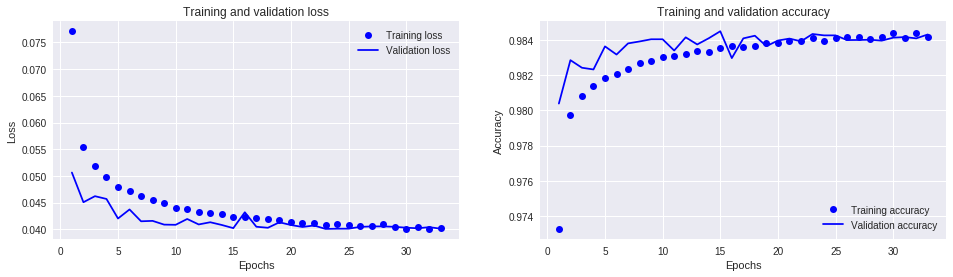

In [0]:
plot_history(history)

In [0]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 17s 539us/step
([0.039349734013894036, 0.9841453720424012], 0.99008139604137)
